In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
import stan_utility

In [3]:
import stan

In [5]:
from faker import Faker # library for generating random num

faker = Faker()
Faker.seed(1000)

# Generate fake data
data_simu = {
    'Pregnancies': [faker.random_int(min=0, max=17) for _ in range(768)],
    'Glucose': [faker.random_int(min=0, max=200) for _ in range(768)],
    'BloodPressure': [faker.random_int(min=0, max=100) for _ in range(768)],
    'SkinTickness': [faker.random_int(min=0, max=100) for _ in range(768)],
    'Insulin': [faker.random_int() for _ in range(768)],
    'BMI': [faker.random.uniform(a=0, b=67) for _ in range(768)],
    'DiabetesPedigreeFunction': [faker.random.uniform(a=0, b=3) for _ in range(768)],
    'Age': [faker.random_int(min=1, max=100) for _ in range(768)],
    'Outcome': [faker.random_int(min=0, max=1) for _ in range(768)]
}


# Create a DataFrame
df_simu = pd.DataFrame(data_simu)

# Display the DataFrame
df_simu.head()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,13,167,55,71,9539,53.598294,1.904902,61,0
1,3,199,33,2,8089,66.511265,2.281294,35,1
2,12,200,10,7,8445,42.163121,0.539516,26,0
3,11,187,19,16,4939,37.179605,0.889850,75,1
4,2,121,12,93,6888,16.559293,0.915431,17,1


# Bayesian Inference

## 1. Bayseian modeling

In [6]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [7]:
import pandas as pd
import csv

In [8]:
import scipy.stats as stats

In [9]:
## import data

df = pd.read_csv('./db/diabetes.csv')

### purpose of analysis
The goal of this analysis is to understand how liklihood of diabetes happened with the age of pregnancies.\
In order to understand it, we will use a bayesian linear regression model.


#### 1. EDA
In order to set initial assumption as prior distribution, we conducted EDA to plot distribution of age and diabetes (DiabetesPedigreeFunction).

source: https://sakurachaojun.github.io/PSYO3505/data/EDA.html

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
# df["age_over35"] = (df['Age'] > 35).astype(int) 

In [13]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


<Axes: >

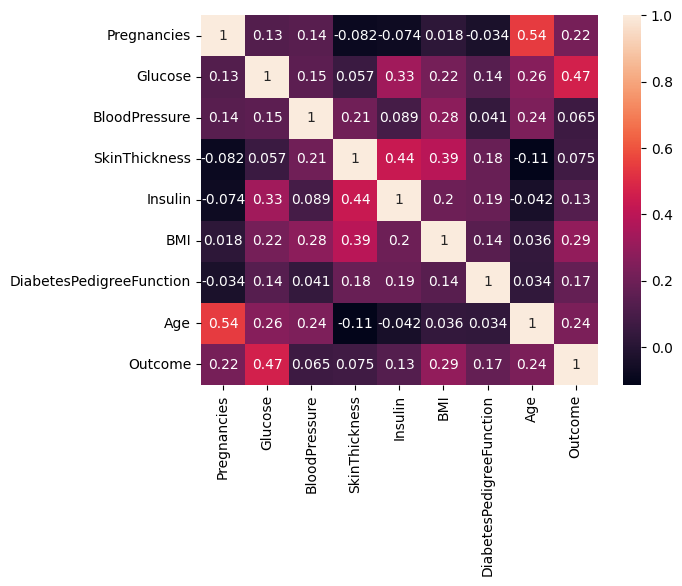

In [24]:
sns.heatmap(df.corr(),annot=True)

<Axes: ylabel='Count'>

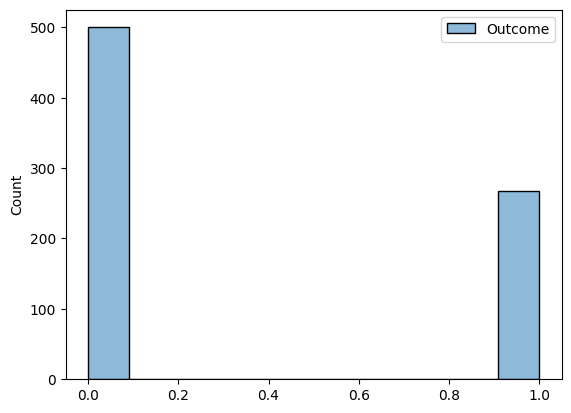

In [25]:
sns.histplot(data=[df['Outcome']])
##age, DiabetesPedigreeFunction

<Axes: ylabel='Count'>

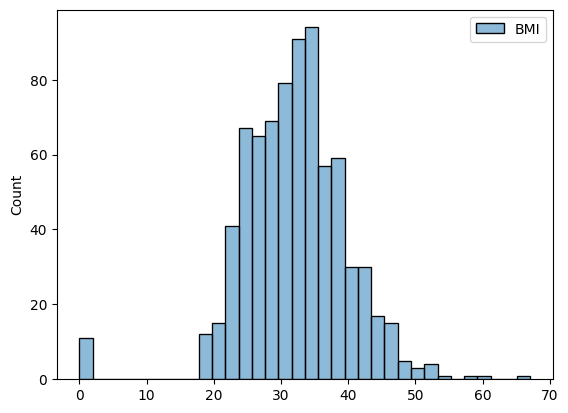

In [18]:
sns.histplot(data=[df['BMI']])


<Axes: ylabel='Count'>

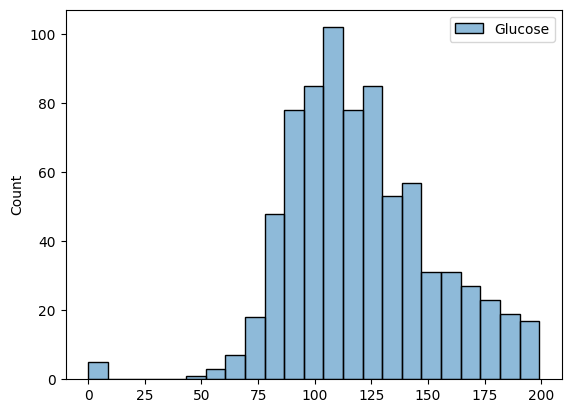

In [19]:
sns.histplot(data=[df['Glucose']])
#age, glucos, BMI

#### Explain the model
1. Data variables
2. Likelihood function and parameters
3. Prior distribution
4. Formal specification
5. Prior predictive check

## 2. Details of the computation



In [20]:
stan_code = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
    int<lower = 0, upper = 1> outcome[N];
     vector[N] glucose;
     vector[N] diabetes;
     vector[N] bmi;
}


parameters {
    //prob of success
    real alpha;
    vector[3] beta;
}


model {
    //prior
    alpha ~ normal(0,1);
    
    vector[N] p;
  
   //linear equation
   p = alpha + beta[1] * glucose + beta[2] * diabetes + beta[3] * bmi;
  
   //likelihood and link function
   outcome ~ bernoulli_logit(p);
}

generated quantities {
    // simulate quantities of interest
   //replications for the posterior predictive distribution
   // create a new variable for the predicted values
  real y_rep[N] = bernoulli_logit_rng(alpha + beta[1] * glucose + beta[2] * diabetes + 
    beta[3] * bmi);
}

"""


### 2-1. Specify data

In [21]:
data = {
"N": len(df), 
"glucose": df.loc[:, "Glucose"].values,
"diabetes": df.loc[:, "DiabetesPedigreeFunction"].values,
"bmi": df.loc[:, "BMI"].values,
"outcome": df.loc[:, "Outcome"].values
}

### 2-2. Build model

In [22]:
stan_model = stan.build(stan_code, data=data)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.5s
Building: 2.6s
Building: 2.7s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 5.7s
Building: 5.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 5.9s
Building: 6.1s
Building: 6.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 6.3s
Building: 6.4s


/Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:245:20: warning: unused variable 'jacobian__' [-Wunused-variable]
    constexpr bool jacobian__ = false;
                   ^
/Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:305:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/cncib3fx/model_cncib3fx.cpp:2:
In file i

Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s


20 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: ob

### 2-3 Fit the model

- quantify with Hamiltonian Monte Carlo


In [23]:
fit = stan_model.sample(num_chains=4, num_samples=1000, num_warmup=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (402/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:  10% (801/8000)
Sampling:  11% (901/8000)
Sampling:  14% (1101/8000)
Sampling:  18% (1401/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  79% (6300/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000204 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000191 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.91 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000185 seconds
  1000 transitions using 10 leapfrog steps p

In [26]:
stan_data_simu = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_rep",
    observed_data=["outcome"],
    posterior_model=stan_model,
    coords={"outcome": np.arange(data["N"])},
)

In [28]:
stan_data_simu

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

[Text(0.5, 1.0, 'Posterior predictive on first data point'),
 Text(0, 0.5, 'Frequency')]

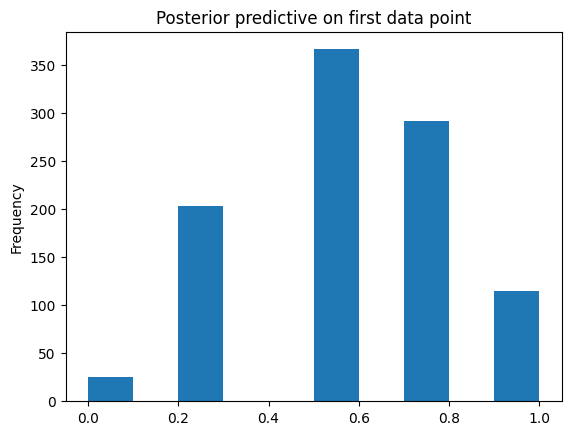

In [29]:
fig, ax = plt.subplots()
ax.hist(stan_data_simu.posterior_predictive.y_rep.values.mean(axis=0)[:,0])
ax.set(title="Posterior predictive on first data point", ylabel="Frequency")

<Axes: xlabel='outcome / y_rep'>

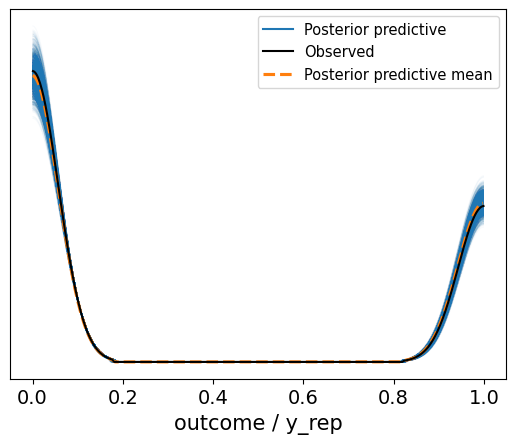

In [30]:
az.plot_ppc(stan_data_simu, data_pairs={"outcome": "y_rep"}, alpha=0.03, textsize=14)

In [31]:
summary1 = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [32]:
summary1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-5.888,0.469,-6.771,-5.005,0.010,0.007,2030.0,1958.0,1.0
beta[0],0.028,0.003,0.023,0.034,0.000,0.000,2655.0,1818.0,1.0
beta[1],0.653,0.259,0.167,1.141,0.005,0.004,2645.0,2093.0,1.0
beta[2],0.046,0.011,0.025,0.066,0.000,0.000,1990.0,2183.0,1.0
y_rep[0],0.567,0.496,0.000,1.000,0.008,0.006,3888.0,3888.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.194,0.395,0.000,1.000,0.006,0.004,4147.0,4000.0,1.0
y_rep[764],0.365,0.481,0.000,1.000,0.008,0.005,3967.0,3967.0,1.0
y_rep[765],0.246,0.431,0.000,1.000,0.007,0.005,3816.0,3816.0,1.0
y_rep[766],0.312,0.463,0.000,1.000,0.007,0.005,4049.0,4000.0,1.0


In [33]:
stan_code_2 = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
    int<lower = 0, upper = 1> outcome[N];
     vector[N] glucose;
     vector[N] diabetes;
     vector[N] bmi;
}


parameters {
    //prob of success
    real alpha;
    vector[3] beta;
}


model {
    //prior
    alpha ~ normal(0,1);
    beta ~ normal(0.5, 1);
    
    vector[N] p;
  
   //linear equation
   p = alpha + beta[1] * glucose + beta[2] * diabetes + beta[3] * bmi;
  
   //likelihood and link function
   outcome ~ bernoulli_logit(p);
}

generated quantities {
    // simulate quantities of interest
   //replications for the posterior predictive distribution
   // create a new variable for the predicted values
  real y_rep[N] = bernoulli_logit_rng(alpha + beta[1] * glucose + beta[2] * diabetes + 
    beta[3] * bmi);
}

"""


In [34]:
data2 = {
"N": len(df_simu), 
"glucose": df_simu.loc[:, "Glucose"].values,
"diabetes": df_simu.loc[:, "DiabetesPedigreeFunction"].values,
"bmi": df_simu.loc[:, "BMI"].values,
"outcome": df_simu.loc[:, "Outcome"].values
}

In [35]:
stan_model_2 = stan.build(stan_code_2, data=data2)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_bnwwdm46/model_z7bbfmkp.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_bnwwdm46/model_z7bbfmkp.stan', line 38, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [36]:
fit_2 = stan_model_2.sample(num_chains=4, num_samples=1000, num_warmup=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   3% (203/8000)
Sampling:   4% (302/8000)
Sampling:   6% (502/8000)
Sampling:   8% (601/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  41% (3300/8000)
Sampling:  58% (4600/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.002095 seconds
  1000 transitions using 10 leapfrog steps per transition would take 20.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002099 seconds
  1000 transitions using 10 leapfrog steps per transition would take 20.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001962 seconds
  1000 transitions using 10 leapfrog steps per transition would take 19.62 seconds.
  Adjust yo

In [37]:
summary2 = az.summary(fit_2) #https://python.arviz.org/en/stable/getting_started/Introduction.html

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [38]:
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.078,0.211,-0.466,0.323,0.006,0.004,1352.0,1697.0,1.0
beta[0],-0.000,0.001,-0.003,0.002,0.000,0.000,2909.0,1909.0,1.0
beta[1],-0.004,0.085,-0.160,0.156,0.002,0.002,1514.0,1827.0,1.0
beta[2],0.004,0.004,-0.003,0.011,0.000,0.000,2129.0,2116.0,1.0
y_rep[0],0.531,0.499,0.000,1.000,0.008,0.005,4126.0,4000.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.501,0.500,0.000,1.000,0.008,0.006,4053.0,4000.0,1.0
y_rep[764],0.521,0.500,0.000,1.000,0.009,0.006,3416.0,3416.0,1.0
y_rep[765],0.487,0.500,0.000,1.000,0.008,0.006,3839.0,3839.0,1.0
y_rep[766],0.511,0.500,0.000,1.000,0.009,0.006,3432.0,3432.0,1.0


In [64]:
stan_data_simu_2 = az.convert_to_inference_data(fit_2, posterior_predictive="y_rep", observed_data=["outcome"], posterior_model=stan_model_2)

In [65]:
stan_data_simu_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='outcome / y_rep'>

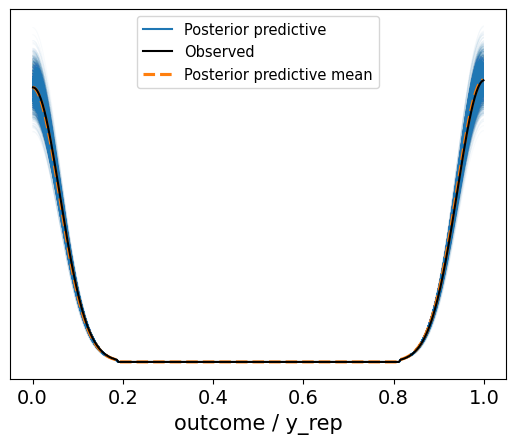

In [66]:
az.plot_ppc(stan_data_simu_2, data_pairs={"outcome": "y_rep"}, alpha=0.03, textsize=14)

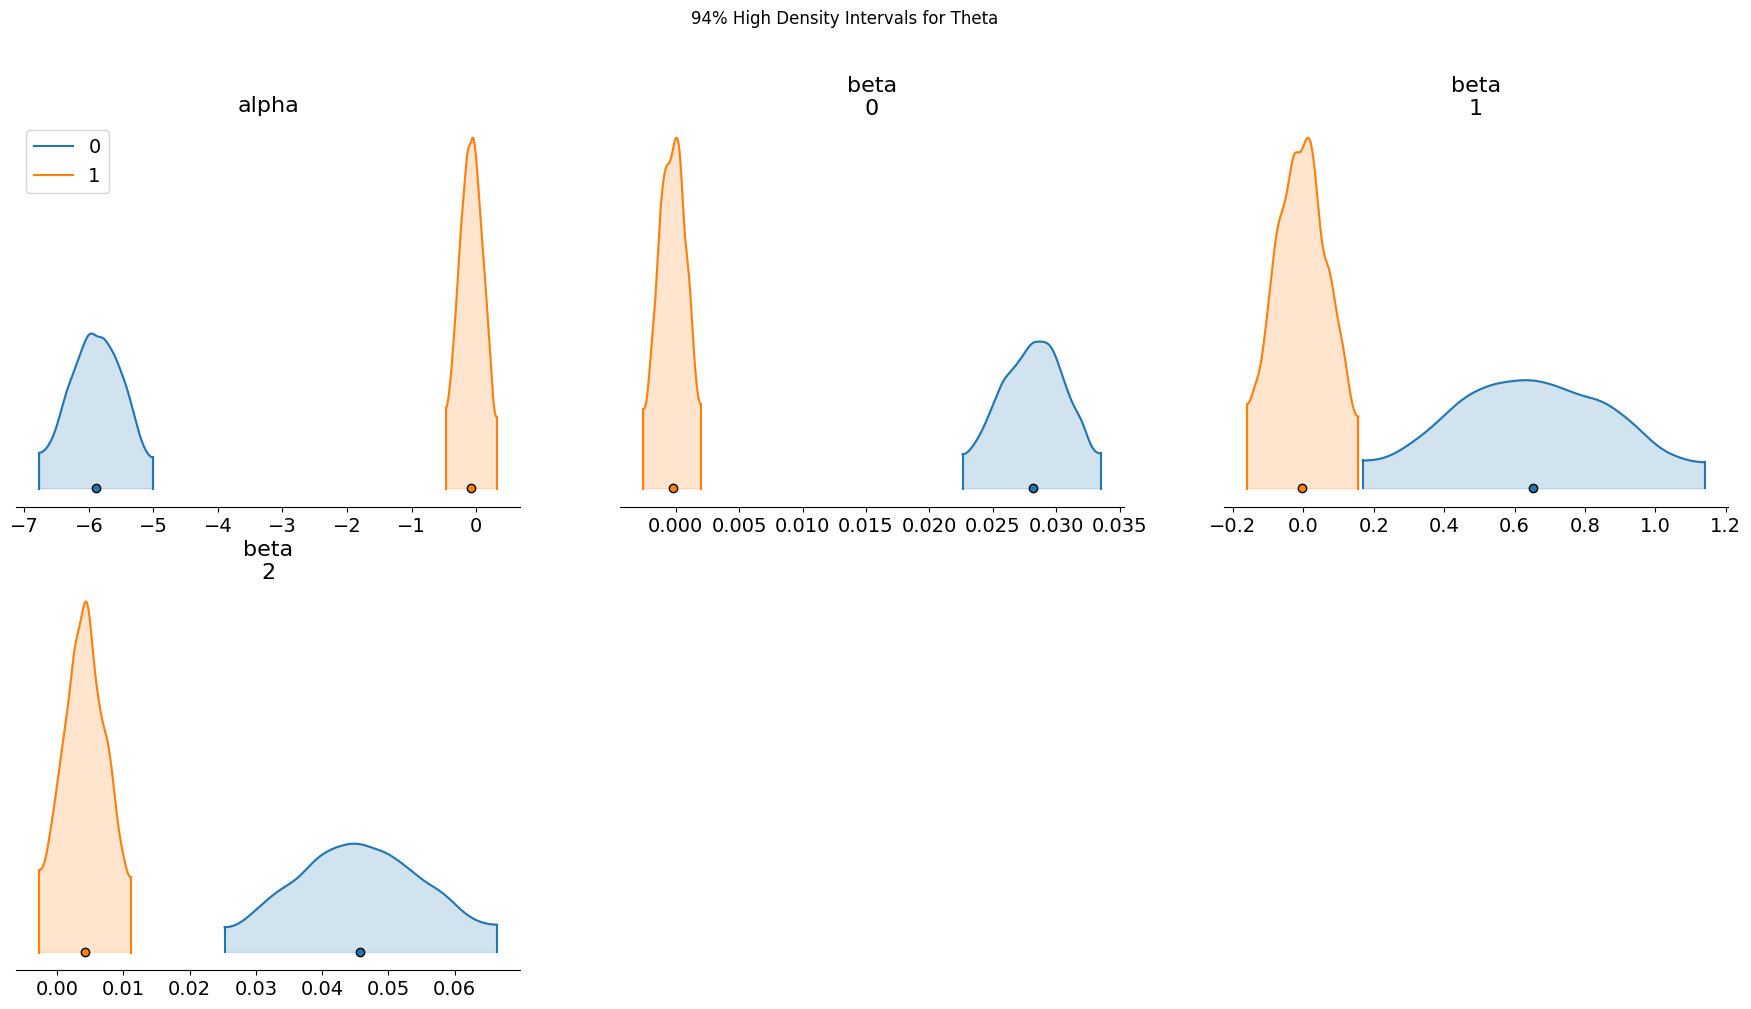

In [50]:
## compare two plots 

axes = az.plot_density(
    [stan_data_simu, stan_data_simu_2],
    group="posterior",
    var_names=["alpha", "beta"],
    shade=0.2,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("94% High Density Intervals for Theta")

plt.show()

## 3. Validate a fit. Diagnostics

The visualization shows that the simulated data sets (diabetes_rep) are different from observed log.

In [ ]:
## diagnostic test with treedepth 

def check_treedepth(summary, max_treedepth = 10, quiet=False):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    # sampler_params = fit.get_sampler_params(inc_warmup=False)
    sampler_params = summary.sample_stats['tree_depth'].values
    depths = [x for y in sampler_params for x in y]
    n = sum(1 for x in depths if x == max_treedepth)
    N = len(depths)

    if not quiet:
        print(('{} of {} iterations saturated the maximum tree depth of {}'
              + ' ({}%)').format(n, N, max_treedepth, 100 * n / N))
    if n > 0:
        if not quiet:
            print('  Run again with max_treedepth set to a larger value to avoid saturation')
        else:
            return False
    else:
        if quiet:
            return True

In [ ]:
## diagnostic test with divergence

def check_div(summary, quiet=False):
    """Check transitions that ended with a divergence"""
    sampler_params = summary.sample_stats['diverging'].values
    divergent = [x for y in sampler_params for x in y]
    # n = sum(divergent)
    divergent = [True if element == "True" else False for element in divergent]
    n = divergent.count(True)
    N = len(divergent)
    if not quiet:
        print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))

    if n > 0:
        if not quiet:
            print('  Try running with larger adapt_delta to remove the divergences')
        else:
            return False
    else:
        if quiet:
            return True

In [ ]:
output = fit2.to_frame()

In [ ]:
output

In [ ]:
summary = az.summary(fit2) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [ ]:
summary
## mcse_mean : Markov Chain Standard Error statistic
## ess_bulk : effective sample size  


In [ ]:
check_treedepth(stan_data_simu_post)

In [ ]:
check_div(stan_data_simu_post)

In [ ]:
filtered_df = summary[summary['r_hat'] > 1.0]

In [ ]:
filtered_df

In [ ]:
az.plot_trace(stan_data_simu_post, compact=False);

In [ ]:
az.plot_posterior(fit)

## 0. delete cache of model

In [ ]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [ ]:
httpstan.cache.list_model_names()

In [ ]:
httpstan.cache.delete_model_directory('models/yroe7ifa') ## add the model pointer you want to remove

## 0. Saving model (not done)

In [ ]:

def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [ ]:
# save(model, 'norm_model.pic')
# new_model = load('norm_model.pic')


In [ ]:
import pickle

In [ ]:
# with open("model_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# fit_new = data_dict['fit']
# # fit = data_list[1]

In [ ]:
# with open("model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : stan_model, 'fit' : fit}, f, protocol=-1)
#     # or with a list
#     # pickle.dump([model, fit], f, protocol=-1)